## Pretrained GAN

In [1]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.vision import *
from fastai.vision.gan import *

## Reading in the data

I had downloaded the data already into **~/tutorials/course-v3/data/img_align_celeba**

In [2]:
path = '/home/jupyter/tutorials/course-v3/data/img_align_celeba/train/celebs'

In [18]:
import os
os.listdir(path);

In [12]:
os.getcwd()

'/home/jupyter/tutorials/course-v3/nbs/dl1'

In [3]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [28]:
data = get_data(128, 64)

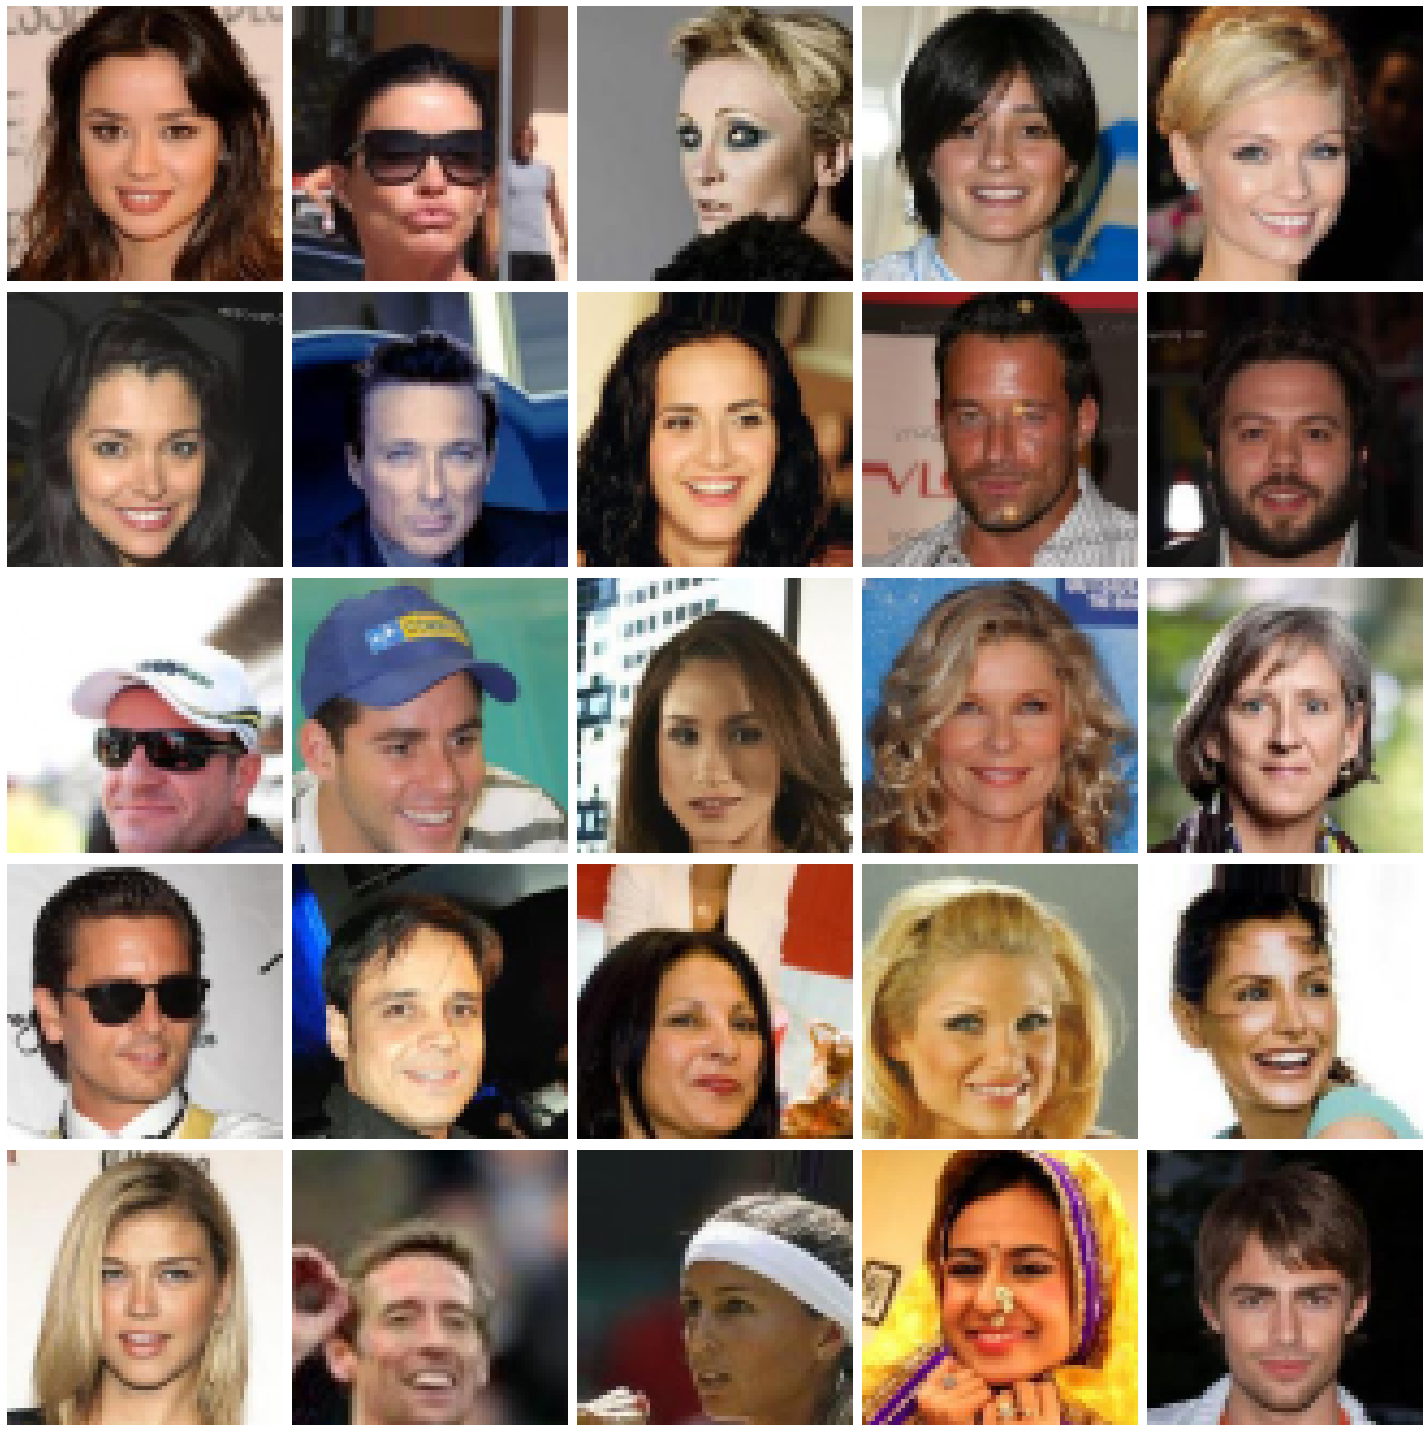

In [29]:
data.show_batch(rows=5)

## Model

Prepare the input data by crappifying images.

In [5]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [6]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

NameError: name 'data' is not defined

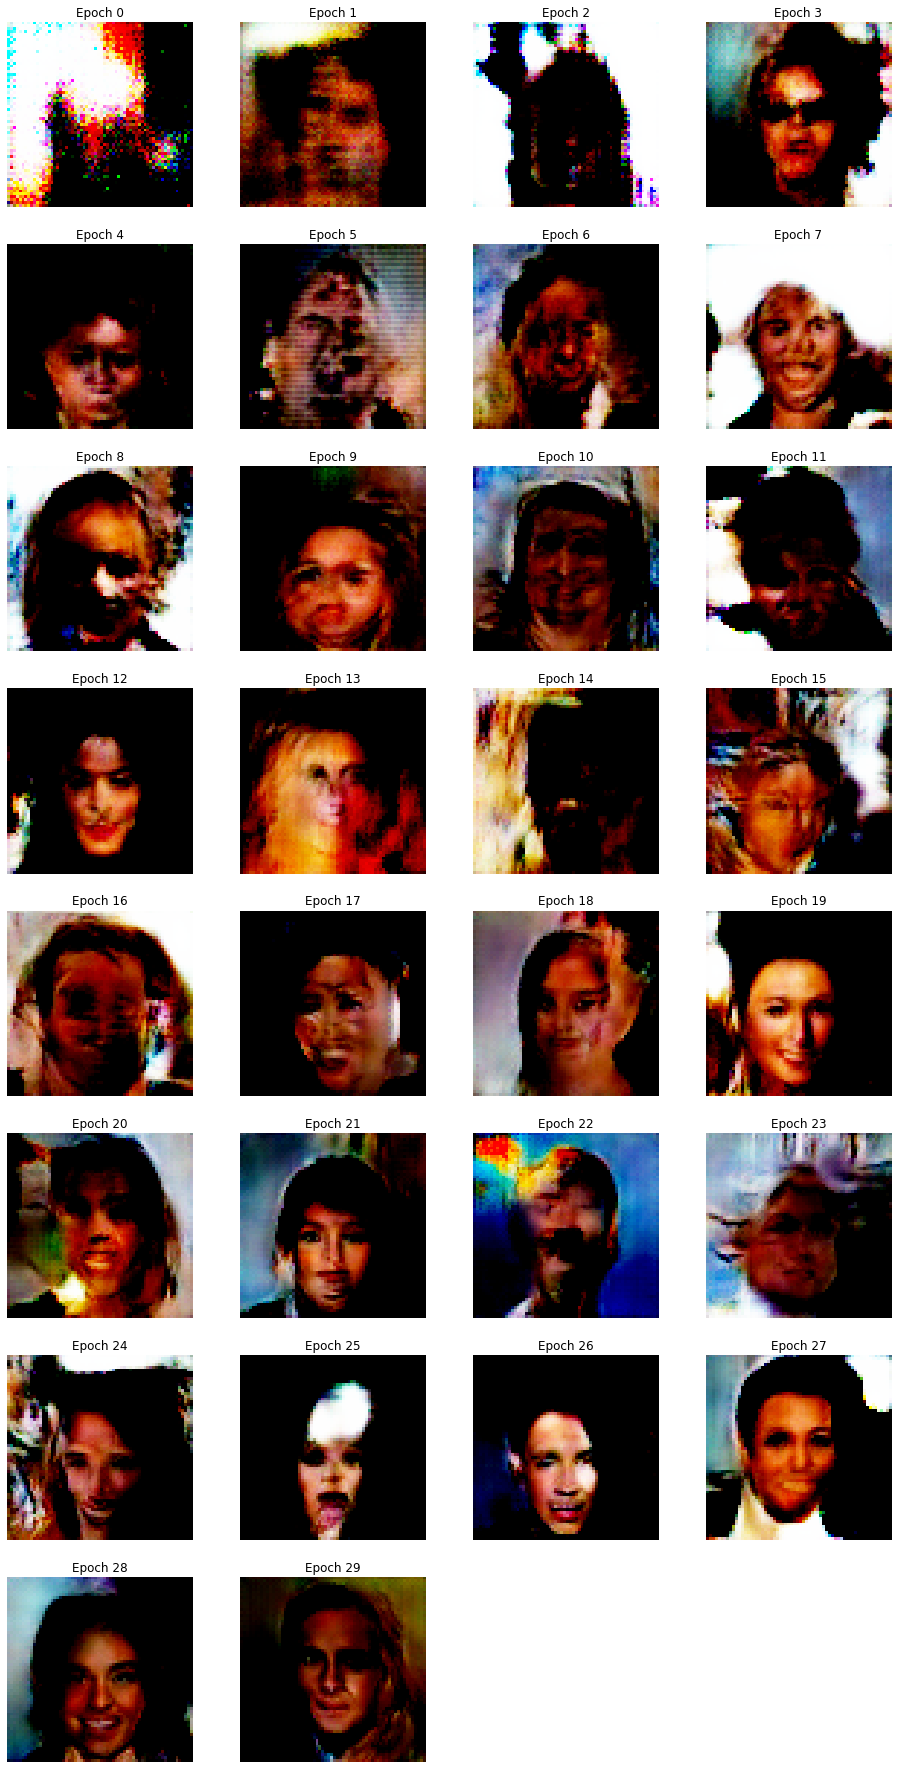

In [32]:
learn.fit(30,2e-4)

## A few generated Images

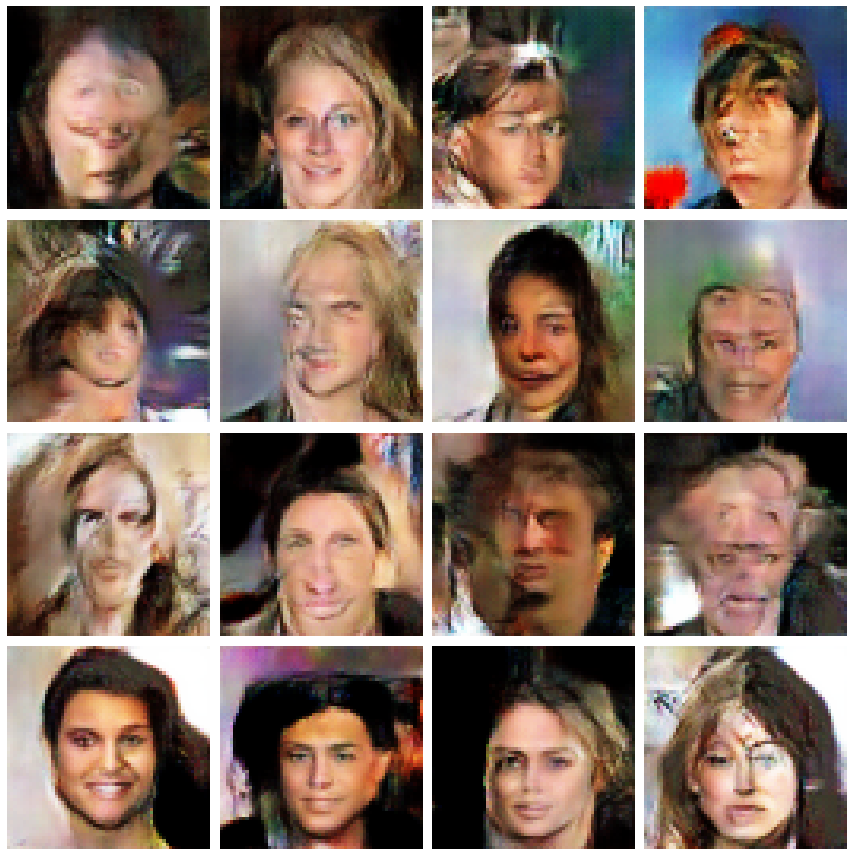

In [53]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(12,12))

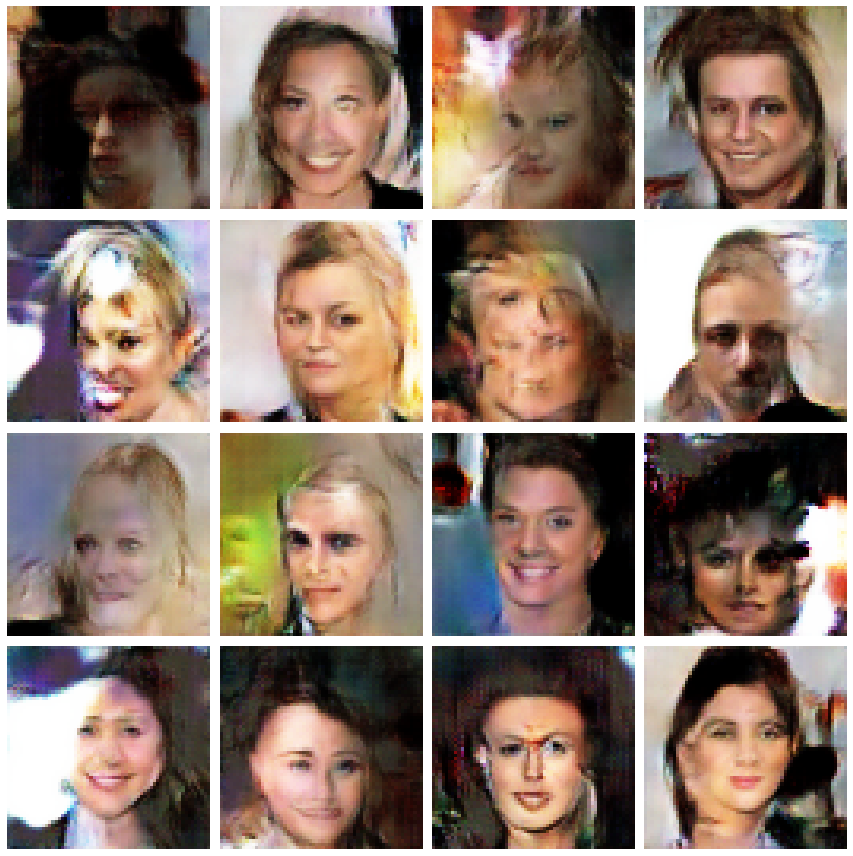

In [61]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(12,12))

## Train a little bit more and see if we get any better

In [64]:
learn.save('30epochs')

In [65]:
learn.unfreeze()

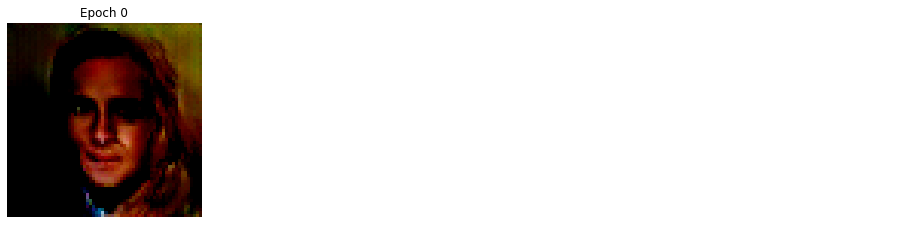

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


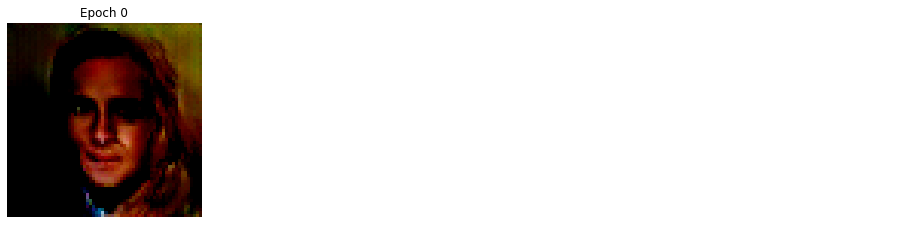

In [66]:
learn.lr_find()

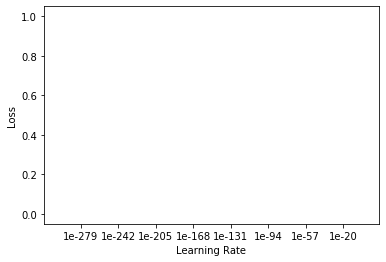

In [67]:
learn.recorder.plot()

In [4]:
learn.load('30epochs');

NameError: name 'learn' is not defined

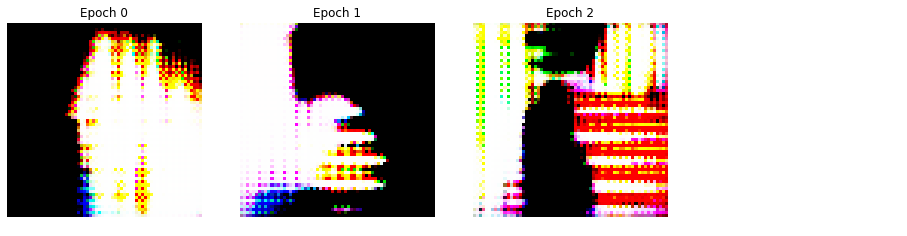

In [72]:
learn.fit_one_cycle(3)

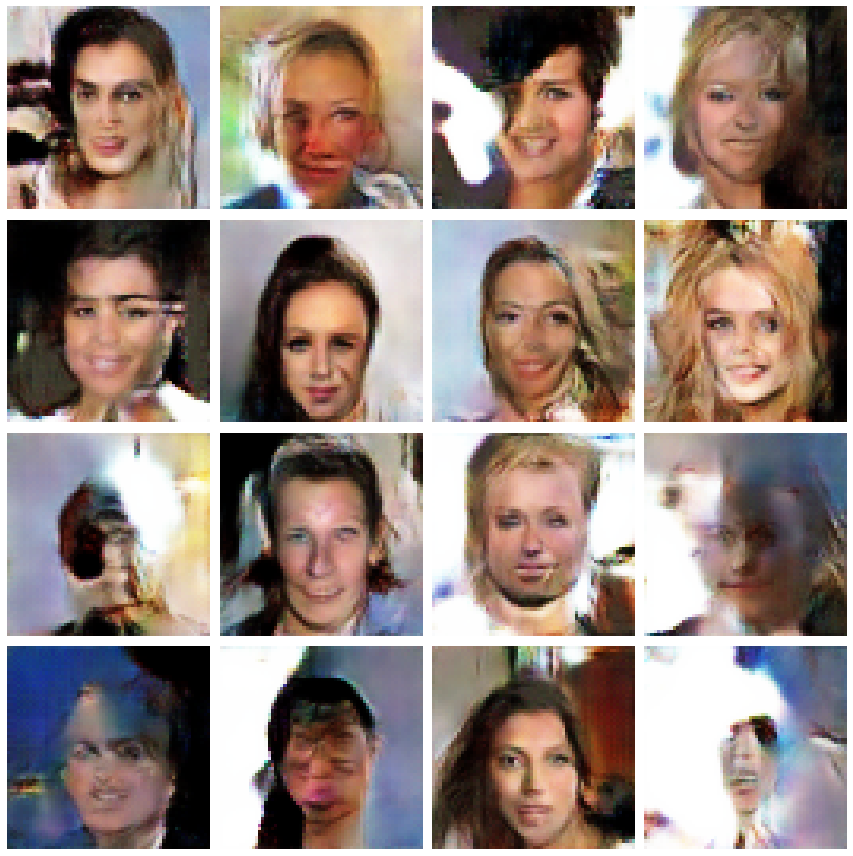

In [75]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(12,12))

## Train with larger resolution images

In [17]:
data = get_data(64, 128)

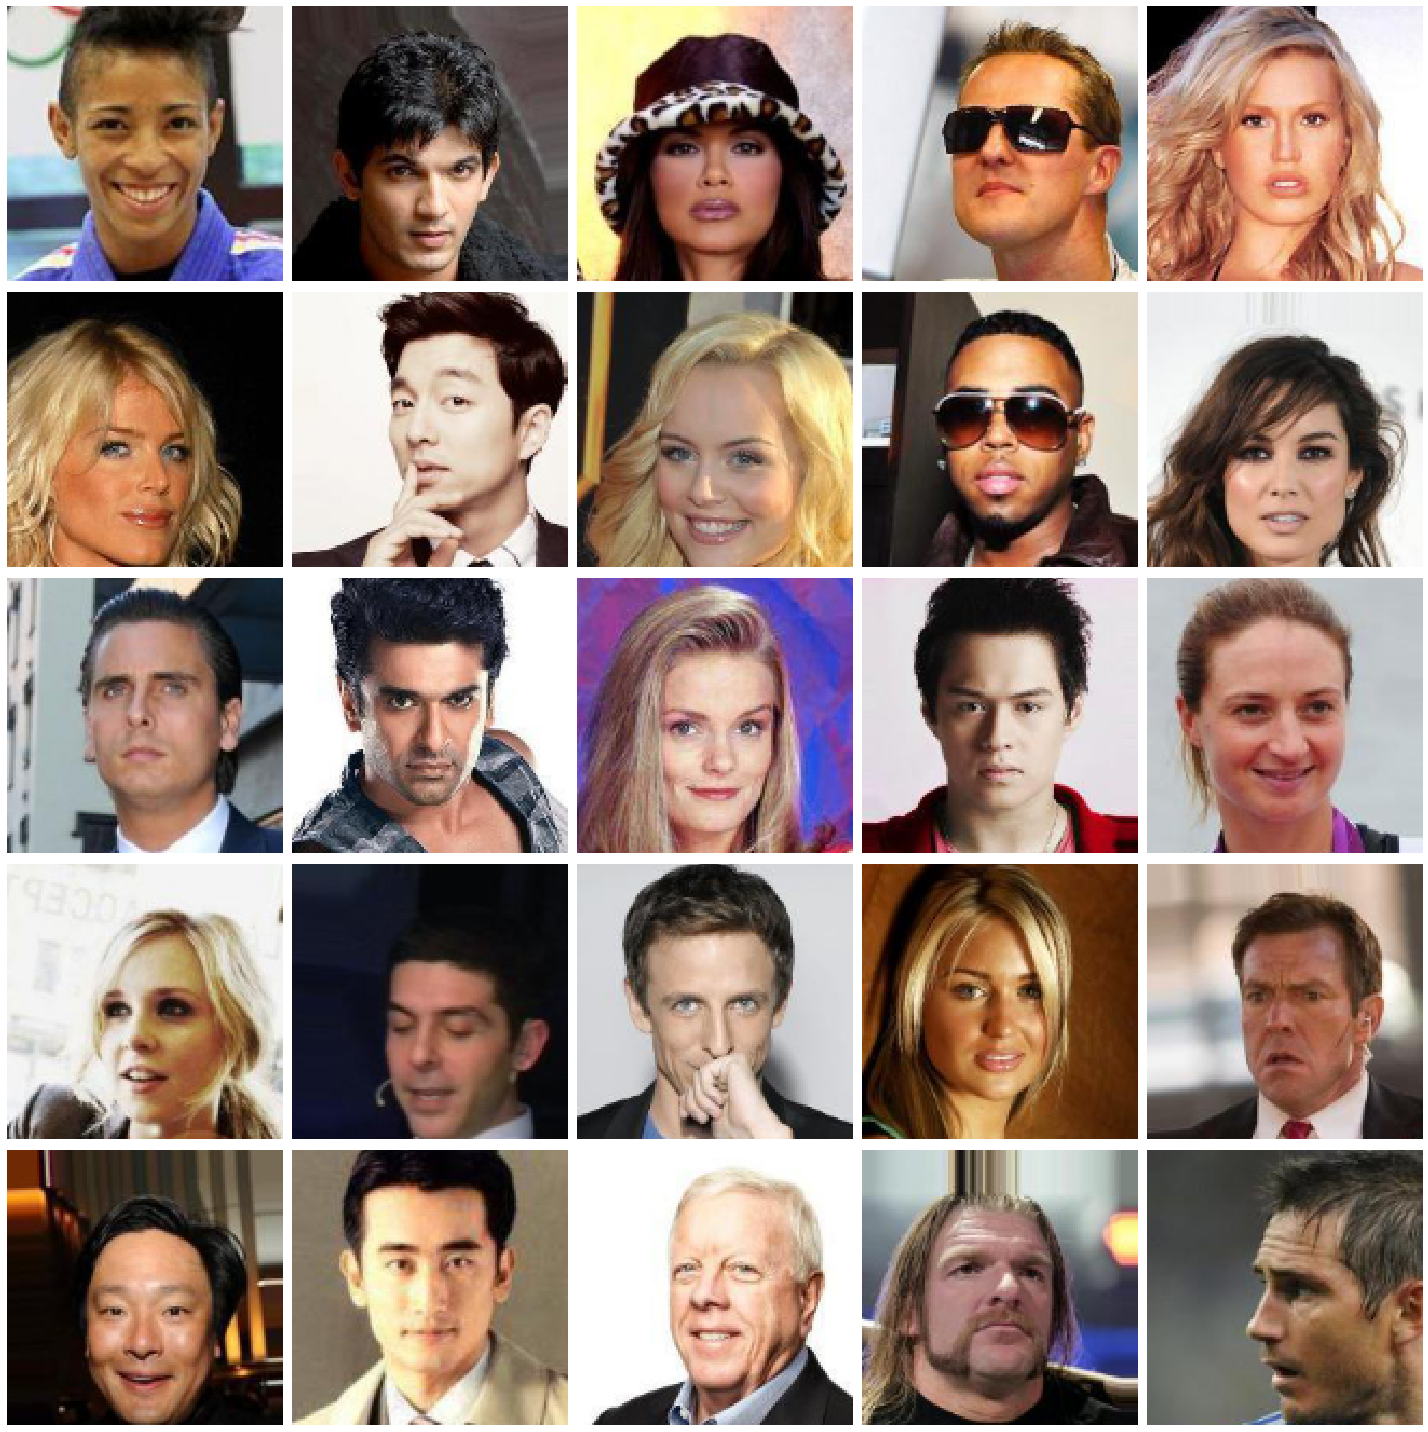

In [18]:
data.show_batch(rows=5)

In [19]:
generator = basic_generator(in_size=128, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=128, n_channels=3, n_extra_layers=1)

In [20]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

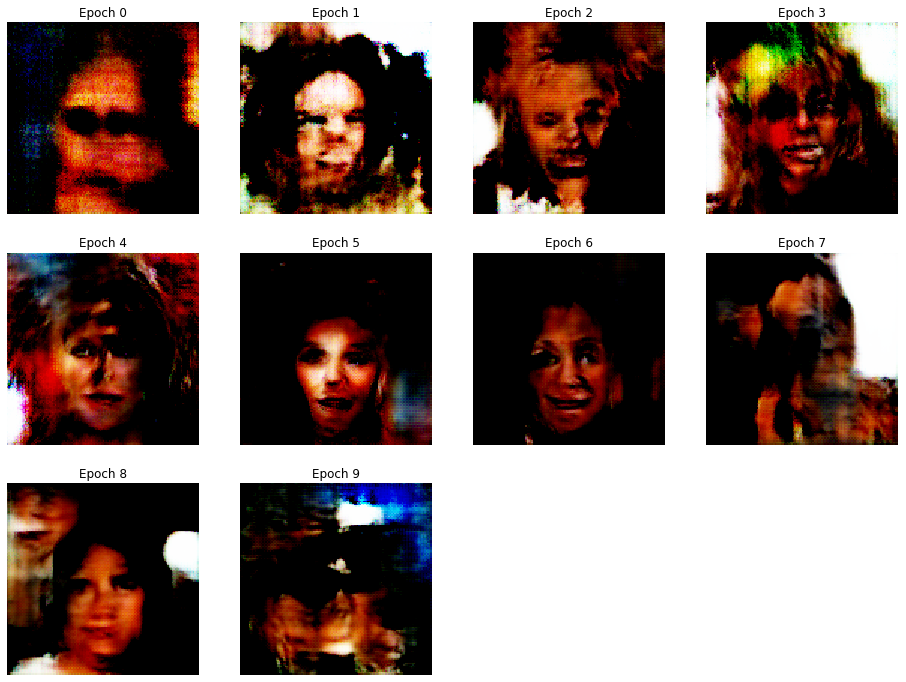

In [21]:
learn.fit(10,2e-4)

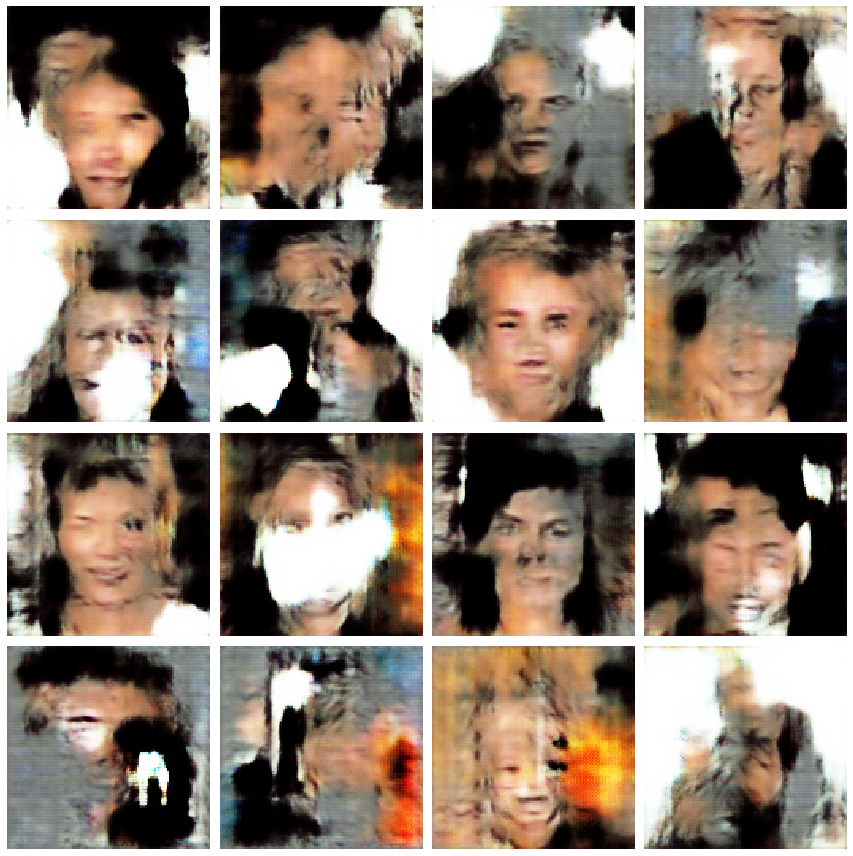

In [22]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(12,12))

## Can we use a pre trained generator?

In [82]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256

In [83]:

def get_data(bs,size):
    data = (ImageImageList.from_folder(path).split_by_rand_pct(0.1, seed=42)
           .label_from_func(noop)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data


In [92]:
data_gen = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [94]:
data_gen.classes

['celebs']

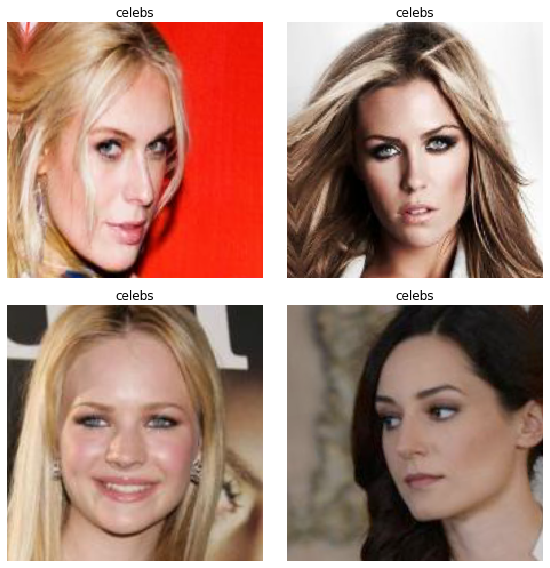

In [93]:
data_gen.show_batch(2)

In [95]:
learn_gen = cnn_learner(data_gen, models.resnet34)

In [96]:
learn_gen.fit_one_cycle(4)

In [98]:
learn_gen.save('gen-34-1')

## Discriminator

In [121]:
#Use the same level of training.
learn_disc = cnn_learner(data_gen, models.resnet34)
learn_disc.load('gen-34-1')

Learner(data=ImageDataBunch;

Train: LabelList (162080 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
celebs,celebs,celebs,celebs,celebs
Path: /home/jupyter/tutorials/course-v3/data/img_align_celeba/train/celebs;

Valid: LabelList (40519 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
celebs,celebs,celebs,celebs,celebs
Path: /home/jupyter/tutorials/course-v3/data/img_align_celeba/train/celebs;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(

## GAN Setup

In [118]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_disc, show_img=False, wd = 0.
                                 ,opt_func=partial(optim.Adam, betas=(0.,0.99)))
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [119]:
learn.fit(10,1e-4)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64, but got 1-dimensional input of size [64] instead

In [120]:
doc(GANLearner)

class GANLearner [source] [test] GANLearner ( data : DataBunch , generator : Module , critic : Module , gen_loss_func : LossFunction , crit_loss_func : LossFunction , switcher : Callback = None , gen_first : bool = False , switch_eval : bool = True , show_img : bool = True , clip : float = None , ** learn_kwargs ) :: Learner 
 
 × No tests found for GANLearner . To contribute a test please refer to this guide and this discussion . A Learner suitable for GANs. 
 Show in docs